# BAC: Block Arithmetic Coding

I developed BAC (Block Arithmetic Coding) back in the 1980's and 1990's.  For several reasons, I've become interested in this problem again.  

This notebook discusses BAC and presents code to calculate its coding efficiency. BAC was presented in Ref [1] below.

Note: see companion notebook for encoder and decoder code.  

-- Charles Boncelet, <boncelet@udel.edu>, 3/29/17

In [1]:
#python 3.6
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

#utility function
def entropy(p):
    """binary entropy function with parameter p"""
    return -p*np.log2(p)-(1-p)*np.log2(1-p)

## BAC (Block Arithmetic Coding) Basics

BAC (Block Arithmetic Coding) is a variable to fixed (VtoF) encoding.  Here we describe the coder for IID binary inputs, but BAC works perfectly well for non-binary, non-stationary, and/or Markov inputs.

For each input bit $x$, BAC recursively divides the set of available output codewords into two non-empty groups, one for $x=1$ and one for $x=0$.  The size (number of codewords) in each group is proportional to the probability of that group, i.e., $k$ codewords are divided into $k_0$ and $k_1$ with $k_0+k_1=k$ and $k_1 \approx pk$ and $k_0 \approx (1-p)k$.  The recursion continues until the group contains only one codeword.  That codeword represents that input phrase.

The expected length of a BAC input phrase is

$$ E(L(k)) = 1 + p E(L([pk]) + (1-p)E(L(k-[pk]))$$

where $k_1=[pk]$ is a rounding of $pk$ with the restrictions that $1\le k_1 \le k-1$.  This also guarantees $1 \le k_0 = k-[pk] \le k-1$.

## BAC Example

Let $p=\Pr(x=1)=0.3$ and let $k=16$ (i.e., 4 bit codewords).  Index the output codewords from 0000 to 1111, or, more simply, from 0 to 15.

Generate some random bits with probability $p$:

In [2]:
#uncomment to generate bits
#p = 0.3
#bits = 1*(np.random.rand(10)<p)
#bits

The sequence I got was [1, 0, 0, 0, 0, 0, 0, 0, 0, 0].  Index the output codewords from 0 to 15.

1. The first bit is a 1.  Let $k_1 = [0.3\times 16] = [4.8] = 5$.  Thus, $x=1$ corresponds to the last five codewords, $\{11, 12, 13, 14, 15\}$.

2. The second bit is a 0.  Let $k_0 = [0.7\times 5] = [3.5] = 3$.  (Both $k_0=3$ and $k_0=4$ are the same distance from $k_0=3.5$; we arbitrarily choose $k_0=3$.)  Thus, the set of codewords is now $\{11, 12, 13\}$.

3. The third bit is a 0.  Let $k_0 = [0.7\times 3] = 2$.  The set of codewords is $\{11, 12\}$.

4. The fourth bit is a 0.  Since the set only has two codewords, the division is trivial: codeword 11 is chosen (if the bit were a 1, codeword 12 would be chosen).

Thus the input sequence 1000 is encoded by codeword 11 = 1011.  

The full codebook is below:

|Index|Input Phrase|Output Code|
|-----|-------------|----------|
| 0  | 0000000 | 0000 |
| 1  | 0000001 | 0001 |
| 2  | 000001  | 0010 |
| 3  | 00001   | 0011 |
| 4  | 00010   | 0100 |
| 5  | 00011   | 0101 |
| 6  | 0010    | 0110 |
| 7  | 0011    | 0111 |
| 8  | 0100    | 1000 |
| 9  | 0101    | 1001 |
| 10 | 011     | 1010 |
| 11 | 1000    | 1011 |
| 12 | 1001    | 1100 |
| 13 | 101     | 1101 |
| 14 | 110     | 1110 |
| 15 | 111     | 1111 |

Note, usually we don't generate the codebook.  We generate the parsing for the specific input on the fly.

The expected input length can be calculated by the standard method:

$$ E(L) = 7(1-p)^7+7(1-p)^6p + 6(1-p)^5p^2 + \cdots + 3p^3 = 4.41 \text{ bits per input phrase}$$ 

Since each codeword uses 4 bits, the normalized rate is $4.41\times h(p)/4 = 0.972$, about 3% worse than entropy. The BAC code is slightly worse than the entropy (as it must be).

In [3]:
p = 0.3
lengths = np.array([7,7,6,5,5,5,4,4,4,4,3,4,4,3,3,3])
ones = np.array([0,1,1,1,1,2,1,2,1,2,2,1,2,2,2,3])
pvector = p**ones * (1-p)**(lengths-ones)
EL = pvector @ lengths
Eff = EL*entropy(p)/4
#Check: the p's must sum to 1
print('Sum(p) = ', np.sum(pvector))
print('EL = ', EL, 'bits per input phrase')
print('Coding Efficiency = %.3f' % Eff, 'and entropy = %.3f' % entropy(0.3))

Sum(p) =  1.0
EL =  4.412719 bits per input phrase
Coding Efficiency = 0.972 and entropy = 0.881


## Recursive Algorithm for Expected Input Phrase Length

The standard algorithm requires us to actually compute the codebook.  For large codebooks, this is expensive (slow).  Fortunately, the recursive definition of the BAC code yields a recursive solution to the expected input length:

$$ EL(k) = 1 + pEL(k_1) + (1-p)EL(k_0)$$

with the boundary conditions $EL(0)=EL(1)=0$.  

E.g. $EL(16) = 1+0.7 EL(11)+0.3EL(5)$, and $EL(11) = 1+0.7EL(8)+0.3EL(3)$, etc.

The code below also gives 4.4127.

## BAC code for calculating Expected Input Phrase Length

The BAC class below works with binary inputs and calculates the expected input phrase length of a BAC encoding with $k$ codeworks, i.e., each input phrase is encoded with $\log_2(k)$ bits.

In [4]:
#reset if recursion problems arise, default = 1000
#import sys
#sys.setrecursionlimit = 2000

In [5]:
class BAC:
    def __init__(self,p,loopfirst=0):
        self.p = p
        self.els = {0:0,1:0}
        #initialize dictionary with loop for small k
        if loopfirst > 0:
            self.calc_loop(loopfirst)
        
    def calc_loop(self,k):
        """use loop to calculate codelengths, fast for small k"""
        for k in range(1,k+1):
            k1 = round(self.p*k)
            if k1 == 0:
                k1 = 1
            if k1 == k:
                k1 = k-1
            k0 = k-k1
            self.els[k] = 1 + self.p*self.els[k1] + (1-self.p)*self.els[k0]
    
    def calc(self,k):
        """calculate expected length for k codewords"""
        if k not in self.els:
            k1 = round(self.p*k)
            if k1 == 0:
                k1 = 1
            if k1 == k-1:
                k1 = k-1
            k0 = k-k1
            #call smaller value first, minimizes recursion depth
            if k0 < k1:
                e0 = self.calc(k0)
                e1 = self.calc(k1)
            else:
                e1 = self.calc(k1)
                e0 = self.calc(k0)
            self.els[k] = 1 + self.p*e1 + (1-self.p)*e0
        return self.els[k]

## Examples

First, compute the example above with $p=0.3$ and $k=16$.

In [6]:
code = BAC(0.3)
code.calc(16)

4.412718999999999

### Example with $p=0.95$ 

In [7]:
code = BAC(p=0.95, loopfirst=2**16)
code.calc(k=64)

19.547954674515136

In [8]:
code.calc(2**32), code.calc(2**48), code.calc(2**64)

(109.7022288182992, 165.5529325173578, 221.41910059802296)

Notice the answer above: we did an exact calculation of the expected input phrase length for a codebook with $2^{64} = 18446744073709551616 = 1.8\times 10^{19}$ codewords.  We couldn't do that calculation if we had to compute the codebook first.

In [9]:
2**64, 64*np.log10(2)

(18446744073709551616, 19.265919722494797)

Calculate the efficiency of the 64 bit code.  It's over 99%. 

In [10]:
code.calc(2**64)*entropy(p=0.95)/64

0.99083994779102502

### Example 48 bit code

Example is given in companion notebook on BAC Encoder and Decoder.

In [11]:
code = BAC(p=0.95, loopfirst=2**16)
code.calc(2**48)

165.5529325173578

### Plot the Input Phrase Length

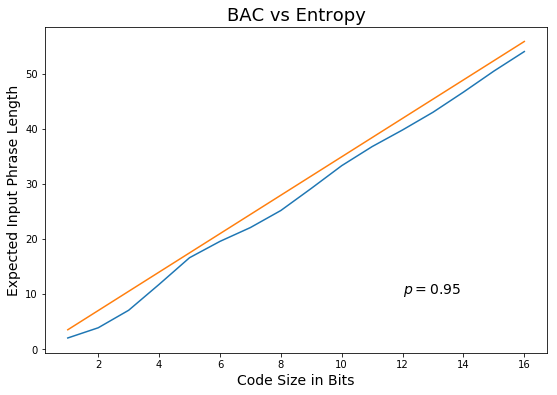

In [12]:
logks = np.arange(1,17).astype('int')
codelengths = [code.calc(2**logk) for logk in logks]
plt.figure(figsize=(9,6))
plt.plot(logks,codelengths)
plt.plot(logks,logks/entropy(code.p))
plt.ylabel('Expected Input Phrase Length',fontsize=14)
plt.xlabel('Code Size in Bits',fontsize=14)
plt.annotate('$p=0.95$', xy=(12,10),fontsize=14)
_ = plt.title('BAC vs Entropy',fontsize=18)

## Comments and Relationship to Tunstall Coding

The most famous VtoF code is the Tunstall code.  The Tunstall code builds a parsing tree by continually breaking the highest probability leaf into two leaves ($m$ leaves for an m-ary alphabet).  The analagy isn't perfect but BAC is more top-down while Tunstall is bottom-up.  BAC is similar to Shannon coding; Tunstall is similar to Huffman coding.

As suggested by the plot above, $\log(k)/h(p) - EL(k) \le C$ for some value of $C$ and for all $k$.  I proved this result in the [cite Trans. Info. Th. paper]. While Tunstall is "optimal", Tunstall originally proved the weaker result that $$\frac{h(p)EL(k)}{\log(k)} \rightarrow 1$$ (Showing the ratio approaches 1 does not imply the difference between $EL(k)$ and $
\log(k)/h(p)$ is bounded.)

BAC has many advantages over Tunstall coding:

1. BAC accomodates much larger alphabets.  The encoding is top-down and the codebook never needs to be stored.

2. BAC gracefully allows non-identically distributed bits. 

3. BAC allows dependency between bits as long as $p(x_n) = f(x_1, x_2, \ldots, x_{n-1})$.  E.g., the input sequence can be Markov or hidden Markov.

## References

1. Boncelet, Charles G. "Block arithmetic coding for source compression." IEEE transactions on information theory 39.5 (1993): 1546-1554.

2. Boncelet, C.G., 1993, January. Block arithmetic coding for Markov sources. In Information Theory, 1993. Proceedings. 1993 IEEE International Symposium on (pp. 118-118). IEEE.